In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [6]:
tf.__version__

'0.12.0-rc0'

In [7]:
import cifar10

In [8]:
cifar10.data_path = "data/CIFAR-10/"

In [9]:
# cifar10.maybe_download_and_extract()

In [10]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [12]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [13]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [14]:
# These are pre-defined values from the cifar-10 module.
from cifar10 import img_size, num_channels, num_classes

In [15]:
# An img_size_cropped is defined to dictate the new, cropped size of 
img_size_cropped = 24

In [16]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

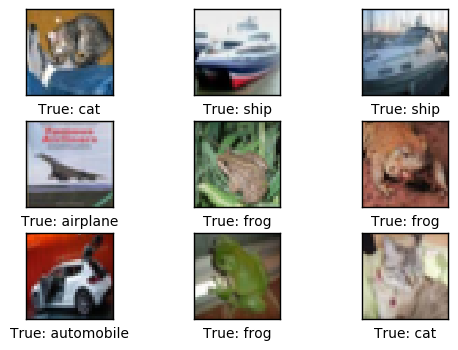

In [17]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

Smoothened Test Images


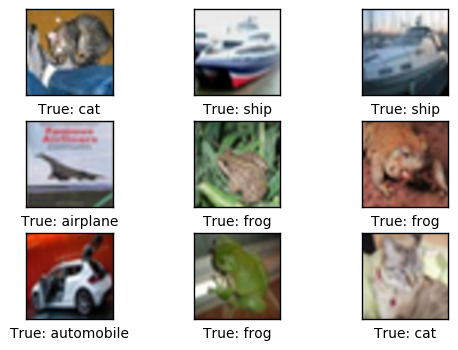

In [18]:
# I will pass in the pixelated images into the NN, I am just smoothening them so we can
# Easily confirm the classifications.

print("Smoothened Test Images")
plot_images(images=images, cls_true=cls_true, smooth=True)

In [19]:
# TF variables are declared.
# This is the input tensor
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
# This is the tensor that holds the class value.
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# This is the tensor that holds the true class in terms of the index that held the largest value.
y_true_cls = tf.argmax(y_true, dimension=1)

In [20]:
# Declaring a function to preprocess the images to increase the training dataset
# by adding certain enhancements to the images like hue, saturation, flips, crops.

# The fn takes in an input image and a bool, whether to build a training or testing graph.

def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [21]:
# This is a helper function that calls pre-process_image for every single input image
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [22]:
# A helper function to plot the distorted images from the training set.
# It accepts the input image tensor declared as x.
distorted_images = pre_process(images=x, training=True)

In [23]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_convolu1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_convolu2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fconnect1').\
            fully_connected(size=128, name='layer_fconnect2').\
            softmax_classifier(class_count=num_classes, labels=y_true)

    return y_pred, loss

In [24]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [25]:
# This tf variable keeps track of the number of iterations.
# trainable=False means tf will not optimize global_step.
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [26]:
# When training, the important statistic to capture is the loss, so we ignore the predicted value(y_pred)
_, loss = create_network(training=True)

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

In [29]:
# Creating a Neural Network for test-phase/inference-phase
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [30]:
# In order to save the variables so as to avoid training the neural net everytime, a saver is created
saver = tf.train.Saver()

In [31]:
def get_weight_variable(layer_name):
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')
    return variable

In [33]:
# Retrievingt layer weights.
weights_conv_1 = get_weight_variable(layer_name = 'layer_convolu1')
weigths_conv2 = get_weight_variable(layer_name = 'layer_convolu2')

In [34]:
# Retrieving layer outputs.
def get_layer_output(layer_name):
    tensor_name = "network/" +  layer_name + "/Relu:0"
    
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)
    
    return tensor

output_conv1 = get_layer_output(layer_name='layer_convolu1')
output_conv2 = get_layer_output(layer_name='layer_convolu2')

In [35]:
session = tf.Session()

In [36]:
save_dir = 'checkpoints/'

In [37]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = save_dir + 'cifar10_cnn'

In [39]:
try:
    print("Trying t restore last checkpoint...")
    # Using tf to check for the latest saved point
    last_check_pth = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    # Loading data from the last saved check point
    saver.restore(session, save_path =last_chk_path)
except:
    print("Failed to restore checkpoint. Variables initializing instead")
    session.run(tf.global_variables_initializer())

Trying t restore last checkpoint...
Failed to restore checkpoint. Variables initializing instead


In [41]:
train_batch_size = 64
def random_batch():
    num_images = len(images_train)
    idx = np.random.choice(num_images, size=train_batch_size, replace=False)
    
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    
    print("X_BATCH", x_batch)
    print(type(x_batch))
    print("Y_BATCH", y_batch)
    print(type(y_batch))
    return x_batch, y_batch

In [43]:
def optimize(num_iterations):
    start_time=time.time()
    
    for i in range(num_iterations):
        # x_batch = images from the random batch
        # y_true_batch = labels of those images
        x_batch, y_true_batch = random_batch()
        
        feed_dict_train = {x:x_batch, y_true:y_true_batch}
        
        # The optimizer is run using the provided batch of training data
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)
        
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict = feed_dict_train)
            
            msg = "Global Step: {0>6}, Training Batch Accuracy: {1:>6.1%}"
            pring(msg.format(i_global, batch_acc))
        
        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [44]:
# Plotting Errors
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [ ]:
# Plotting the confusion matrix